<a href="https://colab.research.google.com/github/eyalgur1/AutoEncoders/blob/main/UNET_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import numpy as np
import random
import torch.nn.functional as F


class Downsample(nn.Module):
    """
    Combines a convolutional block with max pooling for the downsampling path.
    """
    def __init__(self, in_channels, out_channels):
        """
        Args:
        - in_channels: Number of input channels.
        - out_channels: Number of output channels.
        """
        super().__init__()
        self.conv_block = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        """
        Forward pass through the downsampling block.

        Args:
        - x: Input tensor.

        Returns:
        - Feature map after convolution and downsampling.
        """
        feature_map = self.conv_block(x)
        pooled = self.pool(feature_map)
        return feature_map, pooled


class Upsample(nn.Module):
    """
    Combines an upsampling operation with a convolutional block.
    """
    def __init__(self, in_channels, out_channels):
        """
        Args:
        - in_channels: Number of input channels.
        - out_channels: Number of output channels.
        """
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_block = ConvBlock(in_channels, out_channels)

    def forward(self, x, skip_connection):
        """
        Forward pass through the upsampling block.

        Args:
        - x: Input tensor from the previous layer.
        - skip_connection: Feature map from the corresponding encoder layer.

        Returns:
        - Feature map after upsampling and concatenation with skip connection.
        """
        x = self.upsample(x)
        x = self.pad_and_concat(x, skip_connection)
        return self.conv_block(x)

    @staticmethod
    def pad_and_concat(upsampled, skip_connection):
        """
        Pads the upsampled tensor to match the spatial dimensions of the skip connection.

        Args:
        - upsampled: Tensor from the upsampling layer.
        - skip_connection: Corresponding tensor from the encoder.

        Returns:
        - Concatenated tensor with matched dimensions.
        """
        diff_y = skip_connection.size()[2] - upsampled.size()[2]
        diff_x = skip_connection.size()[3] - upsampled.size()[3]
        upsampled = F.pad(upsampled, [diff_x // 2, diff_x - diff_x // 2, diff_y // 2, diff_y - diff_y // 2])
        return torch.cat([upsampled, skip_connection], dim=1)


class ConvBlock(nn.Module):
    """
    A convolutional block with two convolutional layers, batch normalization, and ReLU activation.
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))

    def forward(self, x):
        return self.block(x)


class UNet(nn.Module):
    """
    U-Net Architecture for Image Segmentation using modular Downsample and Upsample blocks.
    """

    def __init__(self, in_channels=3, out_channels=21):
        super().__init__()

        # Encoder path
        self.down1 = Downsample(in_channels, 64)
        self.down2 = Downsample(64, 128)
        self.down3 = Downsample(128, 256)
        self.down4 = Downsample(256, 512)
        self.down5 = ConvBlock(512, 1024)  # No pooling at the last encoder layer

        # Decoder path
        self.up4 = Upsample(1024, 512)
        self.up3 = Upsample(512, 256)
        self.up2 = Upsample(256, 128)
        self.up1 = Upsample(128, 64)

        # Final output layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        """
        Forward pass through the U-Net model.

        Args:
        - x: Input tensor.

        Returns:
        - Output tensor with segmentation predictions.
        """
        # Encoder path
        e1, p1 = self.down1(x)
        e2, p2 = self.down2(p1)
        e3, p3 = self.down3(p2)
        e4, p4 = self.down4(p3)
        e5 = self.down5(p4)

        # Decoder path
        d4 = self.up4(e5, e4)
        d3 = self.up3(d4, e3)
        d2 = self.up2(d3, e2)
        d1 = self.up1(d2, e1)

        # Final output layer
        return self.final_conv(d1)

    def get_encoder_decoder_params(self):
        """
        Automatically retrieve encoder and decoder parameters based on the naming convention.

        Encoder blocks are identified as attributes starting with 'down'.
        Decoder blocks are identified as attributes starting with 'up' or explicitly listed final layers.

        Returns:
        - encoder_params: List of encoder parameters.
        - decoder_params: List of decoder parameters.
        """
        encoder_params = []
        decoder_params = []

        # Collect encoder and decoder parameters dynamically
        for name, module in self.named_children():
            if name.startswith("down"):  # Identify encoder blocks
                encoder_params += list(module.parameters())
            elif name.startswith("up"):  # Identify decoder blocks
                decoder_params += list(module.parameters())

        # Add explicitly named final layers
        decoder_params += list(self.final_conv.parameters())

        return encoder_params, decoder_params


class MultiClassDiceLoss(nn.Module):
    """
    Compute Dice Loss for multi-class segmentation. Handles multiple classes separately and averages the loss.
    """

    def __init__(self, smooth=1e-6):
        """
        Initialize the Dice loss.

        Args:
        - smooth: Small constant to avoid division by zero.
        """
        super().__init__()
        self.smooth = smooth

    def forward(self, outputs, targets, num_classes):
        """
        Compute the Dice Loss.

        Args:
        - outputs: Predicted logits of shape (batch_size, num_classes, height, width).
        - targets: Ground truth masks of shape (batch_size, height, width).
        - num_classes: Number of classes.

        Returns:
        - Average Dice Loss across all classes.
        """
        if num_classes > 1:
            dice_loss = 0.0
            outputs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities

            for cls in range(num_classes):
                pred_cls = outputs[:, cls, :, :]  # Probability map for class
                target_cls = (targets == cls).float()  # Binary mask for the current class

                intersection = (pred_cls * target_cls).sum()
                union = pred_cls.sum() + target_cls.sum()

                dice_loss += (2.0 * intersection + self.smooth) / (union + self.smooth)

            return 1 - (dice_loss / num_classes)
        elif num_classes == 1:
            outputs = torch.sigmoid(outputs)
            pred_cls = outputs[:, 0, :, :]
            target_cls = targets.float()
            intersection = (pred_cls * target_cls).sum()
            union = pred_cls.sum() + target_cls.sum()
            dice_loss = (2.0 * intersection + self.smooth) / (union + self.smooth)
            return 1 - dice_loss


class DiceCELoss(nn.Module):
    """
    Combine Dice Loss and CrossEntropy Loss for multi-class segmentation.
    """

    def __init__(self, num_classes, class_weights, smooth=1e-6):
        """
        Args:
        - num_classes: Number of classes.
        - class_weights: Weights for each class to address class imbalance.
        - smooth: Small constant for Dice Loss.
        """
        super().__init__()
        self.num_classes = num_classes
        self.dice_loss = MultiClassDiceLoss(smooth)
        if num_classes > 1:
            self.ce_loss = nn.CrossEntropyLoss(weight=class_weights, ignore_index=255)  # Ignore void class
        elif num_classes == 1:
            self.ce_loss = nn.BCEWithLogitsLoss()

    def forward(self, outputs, targets):
        """
        Compute combined loss.

        Args:
        - outputs: Predicted logits.
        - targets: Ground truth masks.

        Returns:
        - Combined loss.
        """
        dice = self.dice_loss(outputs, targets, self.num_classes)
        # Reshape targets for binary case to match the input shape of BCEWithLogitsLoss
        if self.num_classes == 1:
            targets = targets.unsqueeze(1)  # Add a channel dimension to targets
        ce = self.ce_loss(outputs, targets)
        return dice + ce


def set_seed(seed):
    """
    Set a fixed random seed for reproducibility.

    Args:
    - seed: The random seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)  # For CPU
    torch.cuda.manual_seed(seed)  # For current GPU
    torch.cuda.manual_seed_all(seed)  # If using multiple GPUs
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [ ]:
import torch.nn as nn
import torch.optim as optim
import random
import time  # For runtime tracking

def switch_requires_grad(decoder_params, encoder_params, optimize_encoder):
    """
    Switch `requires_grad` for encoder and decoder parameters.

    This is used for the NAM optimization strategy,
    where only one part of the model (encoder or decoder) is trained at a time.

    Args:
    - decoder_params: Parameters of the decoder.
    - encoder_params: Parameters of the encoder.
    - optimize_encoder: Boolean indicating whether to optimize encoder (True) or decoder (False).
    """
    if optimize_encoder:
        for p in decoder_params:
            p.requires_grad = False  # Freeze decoder
        for p in encoder_params:
            p.requires_grad = True   # Enable encoder updates
    else:
        for p in encoder_params:
            p.requires_grad = False  # Freeze encoder
        for p in decoder_params:
            p.requires_grad = True   # Enable decoder updates

def train_model(
        model, train_loader, val_loader, num_epochs, device, class_weights, num_classes,
        optimizer_type="adam", lr_encoder=1e-3, lr_decoder=1e-3, alternating_strategy="epoch"
):
    """
    Generalized training function for U-Net with support for NAM or ADAM optimization.
    It trains the model while tracking batch losses and validation metrics.

    Args:
    - model: The U-Net model to be trained.
    - train_loader: DataLoader providing training data in batches.
    - val_loader: DataLoader providing validation data in batches.
    - num_epochs: Number of epochs for training.
    - device: Device to train the model (e.g., "cuda" or "cpu").
    - class_weights: Class weights for loss computation to handle class imbalance.
    - optimizer_type: "adam" for standard ADAM, "nam" for Neural Alternating Minimization.
    - lr_encoder: Learning rate for the encoder (used for NAM).
    - lr_decoder: Learning rate for the decoder (used for NAM).
    - alternating_strategy: Strategy for switching between encoder and decoder optimization ("epoch" or "batch").

    Returns:
    - model: Trained model.
    - history: Dictionary containing training and validation loss/metrics.
    """
    # Define the loss function
    # Dice + CrossEntropy is used for multi-class segmentation.
    criterion = DiceCELoss(num_classes=num_classes, class_weights=class_weights)

    # Move the model to the specified device (GPU or CPU)
    model = model.to(device)

    # History dictionary to store loss and IoU for training and validation
    history = {'train_loss': [], 'train_optimizer': [], 'val_loss': [], 'val_iou': []}

    # Initialize optimizers based on the specified type
    if optimizer_type == "nam":
        # NAM requires separate optimizers for encoder and decoder
        encoder_params, decoder_params = model.get_encoder_decoder_params()
        encoder_optimizer = optim.Adam(encoder_params, lr=lr_encoder)
        decoder_optimizer = optim.Adam(decoder_params, lr=lr_decoder)
    elif optimizer_type == "adam":
        # Standard ADAM optimizer for the entire model
        optimizer = optim.Adam(model.parameters(), lr=lr_encoder)

    # Set the model to training mode
    model.train()

    # Initialize variable to track total training runtime
    total_training_time = 0

    for epoch in range(num_epochs):
        print(f"[{optimizer_type.upper()}] Epoch {epoch + 1}/{num_epochs}")

        # Start timing for the current epoch
        epoch_training_start = time.time()

        # For NAM, determine which part to optimize based on the alternating strategy
        if optimizer_type == "nam":
            optimize_encoder = not (epoch % 2 == 0) if alternating_strategy == "epoch" else False
            switch_requires_grad(decoder_params, encoder_params, optimize_encoder)

        for batch_idx, (images, masks) in enumerate(train_loader):
            images, masks = images.to(device), masks.to(device)

            # Training step for NAM
            if optimizer_type == "nam":
                if not optimize_encoder:
                    decoder_optimizer.zero_grad()  # Clear decoder gradients
                else:
                    encoder_optimizer.zero_grad()  # Clear encoder gradients

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, masks)  # Compute loss

                loss.backward()  # Backpropagation

                # Optimization step
                if optimize_encoder:
                    encoder_optimizer.step()
                    optimizer_name = "encoder"
                else:
                    decoder_optimizer.step()
                    optimizer_name = "decoder"

                # For batch-wise alternating strategy, toggle optimization target
                if alternating_strategy == "batch":
                    optimize_encoder = not optimize_encoder
                    switch_requires_grad(decoder_params, encoder_params, optimize_encoder)
            else:
                # Training step for ADAM
                optimizer.zero_grad()  # Clear all gradients
                outputs = model(images)
                loss = criterion(outputs, masks)  # Compute loss
                loss.backward()  # Backpropagation
                optimizer.step()  # Update model weights
                optimizer_name = "adam"

            # Log batch-wise loss and optimizer name
            history['train_loss'].append(loss.item())
            history['train_optimizer'].append(optimizer_name)

            # Print batch loss for monitoring
            print(f"[{optimizer_type.upper()}] Batch {batch_idx + 1}, Loss: {loss.item():.4f}")

        # End timing for the current epoch
        epoch_training_end = time.time()
        epoch_training_time = epoch_training_end - epoch_training_start
        total_training_time += epoch_training_time

        print(f"Epoch {epoch + 1} training runtime: {epoch_training_time:.2f} seconds")

        # Perform validation after each epoch
        val_loss, val_iou = evaluate(model, val_loader, device, criterion, num_classes)
        history['val_loss'].append(val_loss)
        history['val_iou'].append(val_iou)

        print(f"[{optimizer_type.upper()}] Validation - Loss: {val_loss:.4f}, IoU: {val_iou:.4f}")

    print(f"Total training runtime (excluding validation): {total_training_time:.2f} seconds")
    print(f"Training complete with {optimizer_type.upper()} optimization.")
    return model, history


In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import VOCSegmentation
import torch

class VOCSegmentationCustom(VOCSegmentation):
    """
    Custom VOCSegmentation dataset class for preprocessing Pascal VOC images and masks.

    This class overrides the `__getitem__` method to apply transformations
    to both images and segmentation masks. It also supports binary classification mode.

    Args:
    - root (str): Root directory where the dataset is stored or will be downloaded.
    - year (str): Dataset year (e.g., "2012").
    - image_set (str): Dataset split ("train", "val", or "test").
    - download (bool): Whether to download the dataset if it is not present.
    - image_size (tuple): Size (height, width) to resize images and masks.
    - binary_class (bool): If True, convert masks to binary (foreground vs. background).
    """
    def __init__(self, root, year="2012", image_set="train", download=False, image_size=(128, 128), binary_class=False):
        super().__init__(root=root, year=year, image_set=image_set, download=download)
        self.binary_class = binary_class

        # Transformations for images (normalization is important for pre-trained models)
        self.transform_image = transforms.Compose([
            transforms.Resize(image_size, interpolation=transforms.InterpolationMode.BICUBIC),  # Resize images to a fixed size
            transforms.ToTensor(),  # Convert images to tensors (range [0, 1])
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to ImageNet stats
        ])

        # Transformations for masks
        self.transform_mask = transforms.Compose([
            transforms.Resize(image_size, interpolation=transforms.InterpolationMode.NEAREST),  # Nearest-neighbor preserves discrete labels
            transforms.PILToTensor()  # Convert masks to tensors (range [0, 255] for multi-class)
        ])

    def __getitem__(self, index):
        """
        Retrieve an image and its corresponding segmentation mask from the dataset.

        Args:
        - index (int): Index of the desired image-mask pair.

        Returns:
        - image (Tensor): Preprocessed image tensor.
        - mask (Tensor): Preprocessed mask tensor.
        """
        # Retrieve raw image and mask
        image, mask = super().__getitem__(index)

        # Apply transformations to the image
        image = self.transform_image(image)

        if self.binary_class:
            # Convert mask to binary (1 for foreground, 0 for background)
            mask = self.transform_mask(mask)
            mask = (mask > 0).float()  # Threshold to binary
            mask = mask.squeeze(0) # remove channel dimension for binary case
        else:
            # Apply mask transformations for multi-class segmentation
            mask = self.transform_mask(mask).squeeze(0).long()  # Squeeze channel dimension and convert to long

        return image, mask

def prepare_dataloader(batch_size=8, image_size=(128, 128), download_data=False, binary_class=False, num_classes=21):
    """
    Prepares DataLoaders for the Pascal VOC dataset and computes class weights for loss balancing.

    Args:
    - batch_size (int): Number of samples per batch.
    - image_size (tuple): Target size (height, width) for resizing images and masks.
    - download_data (bool): Whether to download the dataset if not already present.
    - binary_class (bool): If True, masks will be binary (foreground vs. background).
    - num_classes (int): Number of segmentation classes (default: 21 for Pascal VOC).

    Returns:
    - train_loader (DataLoader): DataLoader for the training set.
    - val_loader (DataLoader): DataLoader for the validation set.
    - class_weights (Tensor): Tensor of class weights to handle class imbalance.
    """
    # Load the training and validation datasets
    train_dataset = VOCSegmentationCustom(
        root="./data", year="2012", image_set="train", download=download_data, image_size=image_size, binary_class=binary_class
    )
    val_dataset = VOCSegmentationCustom(
        root="./data", year="2012", image_set="val", download=download_data, image_size=image_size, binary_class=binary_class
    )

    # Create DataLoaders for training and validation sets
    # The DataLoader iterates over the dataset in batches.
    # For each batch, it calls the dataset’s __getitem__ method for the corresponding indices.
    # num_workers parameter specifies the number of subprocesses (child processes) used for data loading.
    # These child processes work in parallel to load and preprocess batches of data while the main process runs the training loop.
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # Compute class weights from the training dataset to handle class imbalance
    class_counts = torch.zeros(num_classes, dtype=torch.long)
    for _, mask in train_loader:  # Iterate over training masks
        for cls in range(num_classes):
            class_counts[cls] += (mask.flatten() == cls).sum().item()  # Count pixels per class

    # Compute weights inversely proportional to class frequencies
    class_weights = 1.0 / (class_counts + 1e-6)  # Add small value to avoid division by zero
    class_weights[class_counts == 0] = 0  # Set weight to 0 for classes not present in the dataset
    class_weights = class_weights / class_weights.sum()  # Normalize weights to sum to 1
    class_weights = class_weights.to(device)  # Move class_weights to the device

    return train_loader, val_loader, class_weights


In [ ]:
import torch
import matplotlib.pyplot as plt
import os

def evaluate(model, loader, device, criterion, num_classes=1, ignore_index=255):
    """
    Evaluate the model on a given DataLoader and compute both the average loss and mean IoU.

    Args:
    - model: The trained U-Net model.
    - loader: DataLoader (for validation or testing).
    - device: Device (e.g., 'cuda' or 'cpu') where computation will occur.
    - criterion: Loss function to compute the loss during evaluation.
    - num_classes: Total number of segmentation classes in the dataset. Use 1 for binary segmentation.
    - ignore_index: Pixels with this index in the ground truth are ignored in IoU calculation.

    Returns:
    - avg_loss (float): The average loss across the dataset.
    - mean_iou (float): The mean IoU across all valid classes (or foreground for binary).
    """
    model.eval()  # Set the model to evaluation mode (e.g., disables dropout)
    running_loss = 0.0  # Tracks the cumulative loss for averaging

    # Initialize per-class metrics
    intersection_per_class = torch.zeros(num_classes, device=device)
    union_per_class = torch.zeros(num_classes, device=device)

    with torch.no_grad():  # Disable gradient computation for efficiency
        for images, masks in loader:  # Iterate through batches of data
            images, masks = images.to(device), masks.to(device)

            # Ignore the pixels with the specified ignore_index
            valid_mask = masks != ignore_index  # Binary mask for valid pixels

            # Forward pass to compute predictions
            outputs = model(images)  # Output shape: [batch_size, num_classes, height, width] for multi-class
                                     # or [batch_size, 1, height, width] for binary segmentation

            loss = criterion(outputs, masks)  # Compute loss
            running_loss += loss.item()  # Accumulate the batch loss

            # Handle binary vs multi-class segmentation
            if num_classes == 1:
                # For binary segmentation, apply sigmoid and threshold at 0.5
                predictions = (torch.sigmoid(outputs) > 0.5).squeeze(1).long()  # Shape: [batch_size, height, width]
            else:
                # For multi-class segmentation, apply argmax over the channel dimension
                predictions = torch.argmax(outputs, dim=1)  # Shape: [batch_size, height, width]

            for cls in range(num_classes):  # Compute IoU for each class
                pred_cls = (predictions == cls) & valid_mask  # Pixels predicted as `cls`
                mask_cls = (masks == cls) & valid_mask  # Ground truth pixels for `cls`

                # Compute the intersection and union for IoU calculation
                intersection = (pred_cls & mask_cls).sum().float()
                union = (pred_cls | mask_cls).sum().float()

                # Accumulate metrics per class
                intersection_per_class[cls] += intersection
                union_per_class[cls] += union

    # Compute per-class IoU and mean IoU
    iou_per_class = intersection_per_class / (union_per_class + 1e-6)
    if num_classes == 1:
        # For binary, return the IoU for the foreground class
        mean_iou = iou_per_class[0].item()
    else:
        # For multi-class, compute the mean IoU across all valid classes
        mean_iou = iou_per_class[union_per_class > 0].mean().item()

    avg_loss = running_loss / len(loader)  # Average loss across batches
    return avg_loss, mean_iou  # Return average loss and IoU metrics



def plot_training_and_validation(history_nam, history_adam, output_dir="./results"):
    """
    Plot training and validation metrics for NAM and ADAM optimizers.

    Args:
    - history_nam: History dictionary for NAM optimization containing 'train_loss', 'val_loss', and 'val_iou'.
    - history_adam: History dictionary for ADAM optimization containing the same metrics.
    - output_dir: Directory to save the plot.
    """
    os.makedirs(output_dir, exist_ok=True)  # Create directory if not exists
    plt.figure(figsize=(15, 10))  # Configure plot size

    # Plot training loss
    plt.subplot(2, 1, 1)
    colors = {'encoder': 'blue', 'decoder': 'green'}  # Colors for NAM segments
    current_segment_start = 0  # Track the start of each optimizer's segment
    for i in range(1, len(history_nam['train_loss'])):
        if history_nam['train_optimizer'][i] != history_nam['train_optimizer'][i - 1]:  # Detect optimizer switch
            plt.plot(
                range(current_segment_start, i + 1),
                history_nam['train_loss'][current_segment_start:i + 1],
                color=colors[history_nam['train_optimizer'][i - 1]], linestyle='-',
                label=f"{history_nam['train_optimizer'][i - 1].capitalize()} Loss (NAM)" if current_segment_start == 0 else None
            )
            current_segment_start = i
    plt.plot(
        range(current_segment_start, len(history_nam['train_loss'])),
        history_nam['train_loss'][current_segment_start:],
        color=colors[history_nam['train_optimizer'][-1]], linestyle='-'
    )
    plt.plot(range(len(history_adam['train_loss'])), history_adam['train_loss'], label="Training Loss (ADAM)", color='red', linestyle='-')

    plt.xlabel("Batch Index")
    plt.ylabel("Loss")
    plt.title("Training Loss (NAM vs. ADAM)")
    plt.legend()

    # Plot validation metrics
    plt.subplot(2, 1, 2)
    epochs_nam = range(1, len(history_nam['val_loss']) + 1)
    epochs_adam = range(1, len(history_adam['val_loss']) + 1)

    plt.plot(epochs_nam, history_nam['val_loss'], label="Validation Loss (NAM)", color='orange', linestyle='-')
    plt.plot(epochs_nam, history_nam['val_iou'], label="Validation IoU (NAM)", color='purple', linestyle='-')
    plt.plot(epochs_adam, history_adam['val_loss'], label="Validation Loss (ADAM)", color='brown', linestyle='--')
    plt.plot(epochs_adam, history_adam['val_iou'], label="Validation IoU (ADAM)", color='pink', linestyle='--')

    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.title("Validation Loss and IoU (NAM vs. ADAM)")
    plt.legend()

    # Save and display the plot
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "NAM_vs_ADAM_metrics.png"))
    plt.show()


def count_trainable_params(params):
    """
    Count the number of trainable parameters in a model or optimizer parameter group.

    Args:
    - params: Iterable of parameters, e.g., model.parameters() or an optimizer's parameter group.

    Returns:
    - int: Total number of trainable parameters.
    """
    return sum(p.numel() for p in params if p.requires_grad)  # Sum the number of elements for all trainable parameters
    # Includes non-trainable parameters, otherwise set `if p.required_grad`


Preparing DataLoaders...
Instantiating Models...
Synchronizing Initial Weights...
Initial weights are identical for both models!

Training with NAM Optimization...
[NAM] Epoch 1/3
[NAM] Batch 1, Loss: 4.1314
[NAM] Batch 2, Loss: 4.0999
[NAM] Batch 3, Loss: 4.0313
[NAM] Batch 4, Loss: 4.0519
[NAM] Batch 5, Loss: 4.0189
[NAM] Batch 6, Loss: 4.0433
[NAM] Batch 7, Loss: 3.9319
[NAM] Batch 8, Loss: 4.0370
[NAM] Batch 9, Loss: 3.9618
[NAM] Batch 10, Loss: 3.9921
[NAM] Batch 11, Loss: 3.8703
[NAM] Batch 12, Loss: 3.8820
[NAM] Batch 13, Loss: 3.8582
[NAM] Batch 14, Loss: 3.8889
[NAM] Batch 15, Loss: 3.9512
[NAM] Batch 16, Loss: 3.8902
[NAM] Batch 17, Loss: 3.8111
[NAM] Batch 18, Loss: 3.9019
[NAM] Batch 19, Loss: 3.9668
[NAM] Batch 20, Loss: 3.7940
[NAM] Batch 21, Loss: 3.9116
[NAM] Batch 22, Loss: 3.8882
[NAM] Batch 23, Loss: 3.8918
Epoch 1 training runtime: 16.05 seconds
[NAM] Validation - Loss: 4.2752, IoU: 0.0307
[NAM] Epoch 2/3
[NAM] Batch 1, Loss: 4.0609
[NAM] Batch 2, Loss: 4.8120
[NAM]

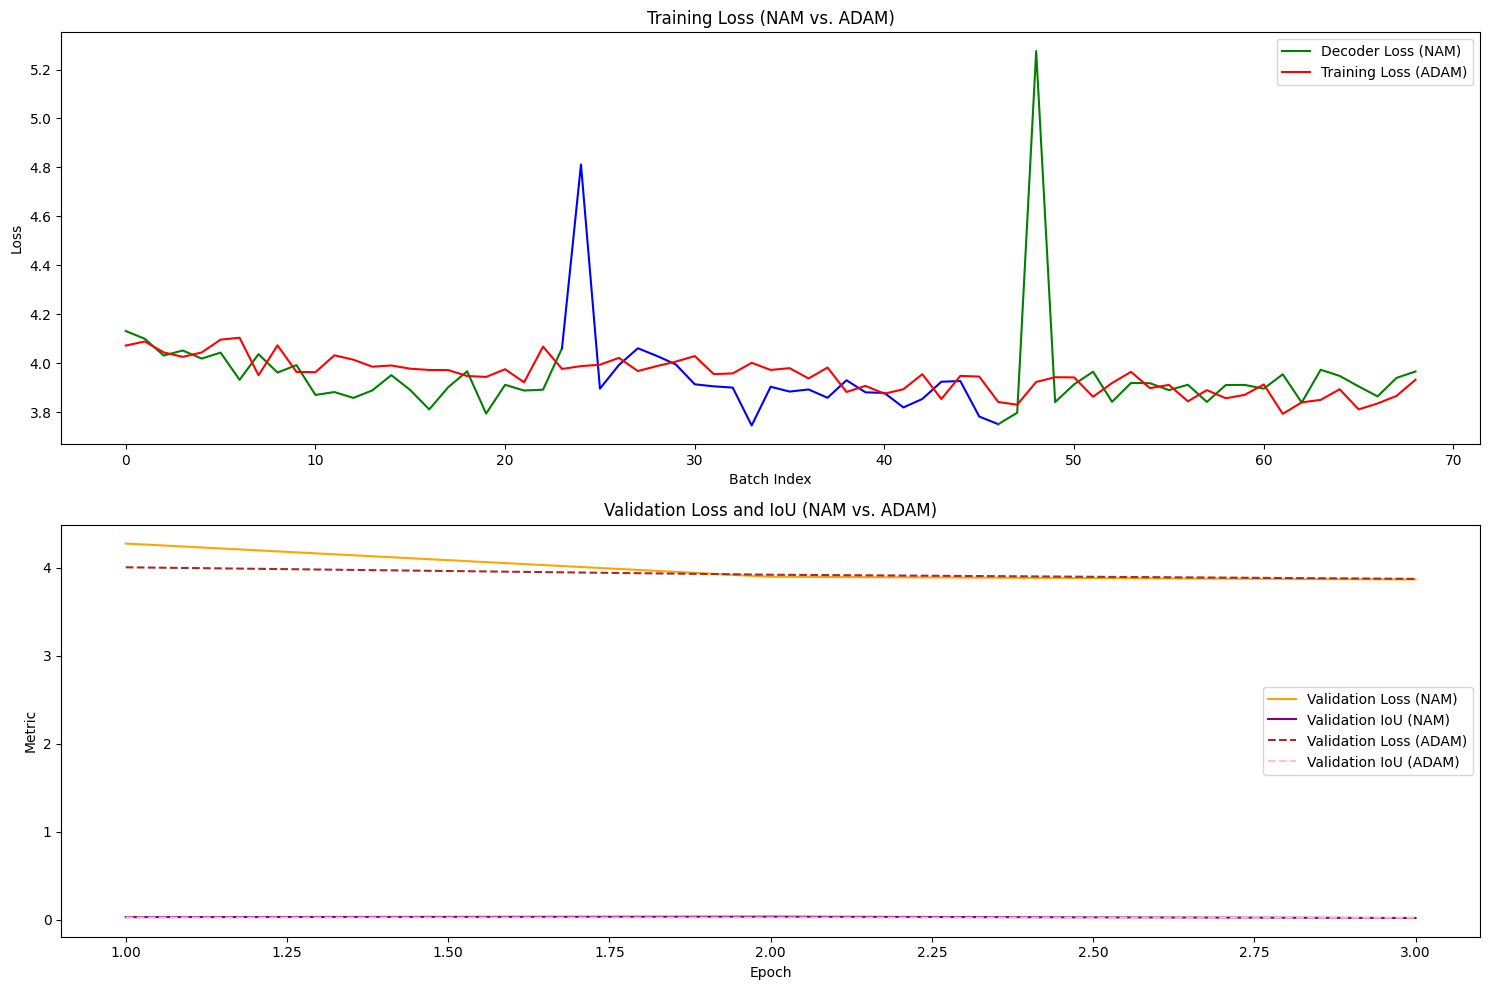


Final Validation Results:
NAM Optimization - Final Validation Loss: 3.8676, Final Validation IoU: 0.0207
ADAM Optimization - Final Validation Loss: 3.8742, Final Validation IoU: 0.0239
Total trainable parameters (ADAM): 31044821
Trainable parameters (NAM Encoder): 0
Trainable parameters (NAM Decoder): 12193685


In [ ]:
import torch


if __name__ == '__main__':
    """
    The `if __name__ == '__main__':` guard is required when using multiprocessing in Python.
    PyTorch's DataLoader uses multiprocessing (when num_workers > 0) to speed up data loading by spawning child processes.
    Without this guard, the script may unintentionally re-run due to process spawning on platforms like Windows.
    """

    # ---------------------
    # Hyperparameters
    # ---------------------
    num_epochs = 3  # Number of training epochs
    batch_size = 64  # Batch size for data loading
    image_size = (128, 128)  # Input image size for resizing
    download_data = False  # Whether to download the dataset (if not already present)
    binary_class = False  # Use multi-class segmentation (set False for multi-class tasks)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available, otherwise CPU
    lr_encoder = 1e-4  # Learning rate for encoder optimization (NAM)
    lr_decoder = 1e-3  # Learning rate for decoder optimization (NAM)
    lr_adam = 1e-4  # Learning rate for standard ADAM optimization
    #seed = 42  # Random seed for reproducibility
    if binary_class:
        out_chan = 1  # Number of output channels for binary segmentation
    else:
        out_chan = 21  # Number of output channels for multi-class segmentation

    # ---------------------
    # Prepare DataLoaders
    # ---------------------
    print("Preparing DataLoaders...")
    train_loader, val_loader, class_weights = prepare_dataloader(
        batch_size=batch_size,
        image_size=image_size,
        download_data=download_data,
        binary_class=binary_class
    )
    # `class_weights` contains the weights for each class, computed from the training dataset.

    # ---------------------
    # Instantiate Models
    # ---------------------
    # Create two U-Net models for comparison (NAM and ADAM optimizers).
    # Both models must start with identical initial weights.
    print("Instantiating Models...")
    model_nam = UNet(in_channels=3, out_channels=out_chan)  # NAM-based model
    model_adam = UNet(in_channels=3, out_channels=out_chan)  # ADAM-based model

    # ---------------------
    # Synchronize Initial Weights
    # ---------------------
    # Save the initial weights from one model (model_adam) and load them into the other (model_nam).
    print("Synchronizing Initial Weights...")
    initial_weights = model_adam.state_dict()  # Save initial weights from the ADAM model
    model_nam.load_state_dict(initial_weights)  # Reset weights for the NAM model

    # Verify that the initial weights are identical for both models
    for p1, p2 in zip(model_nam.parameters(), model_adam.parameters()):
        assert torch.equal(p1, p2), "Initial weights are not the same!"
    print("Initial weights are identical for both models!")

    # ---------------------
    # Train Models
    # ---------------------
    # Train the NAM model
    print("\nTraining with NAM Optimization...")
    trained_model_nam, nam_history = train_model(
        model_nam,
        train_loader,
        val_loader,
        num_epochs,
        device,
        class_weights,
        out_chan,
        optimizer_type="nam",  # NAM optimizer
        lr_encoder=lr_encoder,  # Learning rate for encoder
        lr_decoder=lr_decoder,  # Learning rate for decoder
        alternating_strategy="epoch"  # Alternate encoder/decoder optimization per epoch
    )

    # Train the ADAM model
    print("\nTraining with Standard ADAM Optimization...")
    trained_model_adam, adam_history = train_model(
        model_adam,
        train_loader,
        val_loader,
        num_epochs,
        device,
        class_weights,
        out_chan,
        optimizer_type="adam",  # ADAM optimizer
        lr_encoder=lr_adam  # Single learning rate for ADAM
    )

    # ---------------------
    # Plot Training Results
    # ---------------------
    print("\nPlotting Results for NAM and ADAM Optimization...")
    # Generate plots to compare NAM and ADAM metrics (loss and IoU)
    plot_training_and_validation(nam_history, adam_history)

    # ---------------------
    # Print Final Results
    # ---------------------
    print("\nFinal Validation Results:")
    print(f"NAM Optimization - Final Validation Loss: {nam_history['val_loss'][-1]:.4f}, Final Validation IoU: {nam_history['val_iou'][-1]:.4f}")
    print(f"ADAM Optimization - Final Validation Loss: {adam_history['val_loss'][-1]:.4f}, Final Validation IoU: {adam_history['val_iou'][-1]:.4f}")

    # ---------------------
    # Count Trainable Parameters
    # ---------------------
    # Calculate and display the number of trainable parameters for both models.

    # Total parameters for ADAM
    adam_total_params = count_trainable_params(model_adam.parameters())
    print(f"Total trainable parameters (ADAM): {adam_total_params}")

    # Trainable parameters for NAM (encoder and decoder separately)
    encoder_params, decoder_params = model_nam.get_encoder_decoder_params()
    encoder_trainable_params = count_trainable_params(encoder_params)
    decoder_trainable_params = count_trainable_params(decoder_params)
    print(f"Trainable parameters (NAM Encoder): {encoder_trainable_params}")
    print(f"Trainable parameters (NAM Decoder): {decoder_trainable_params}")


Saved segmentation comparison visualization to ./results/validation_segmentation_comparison.png


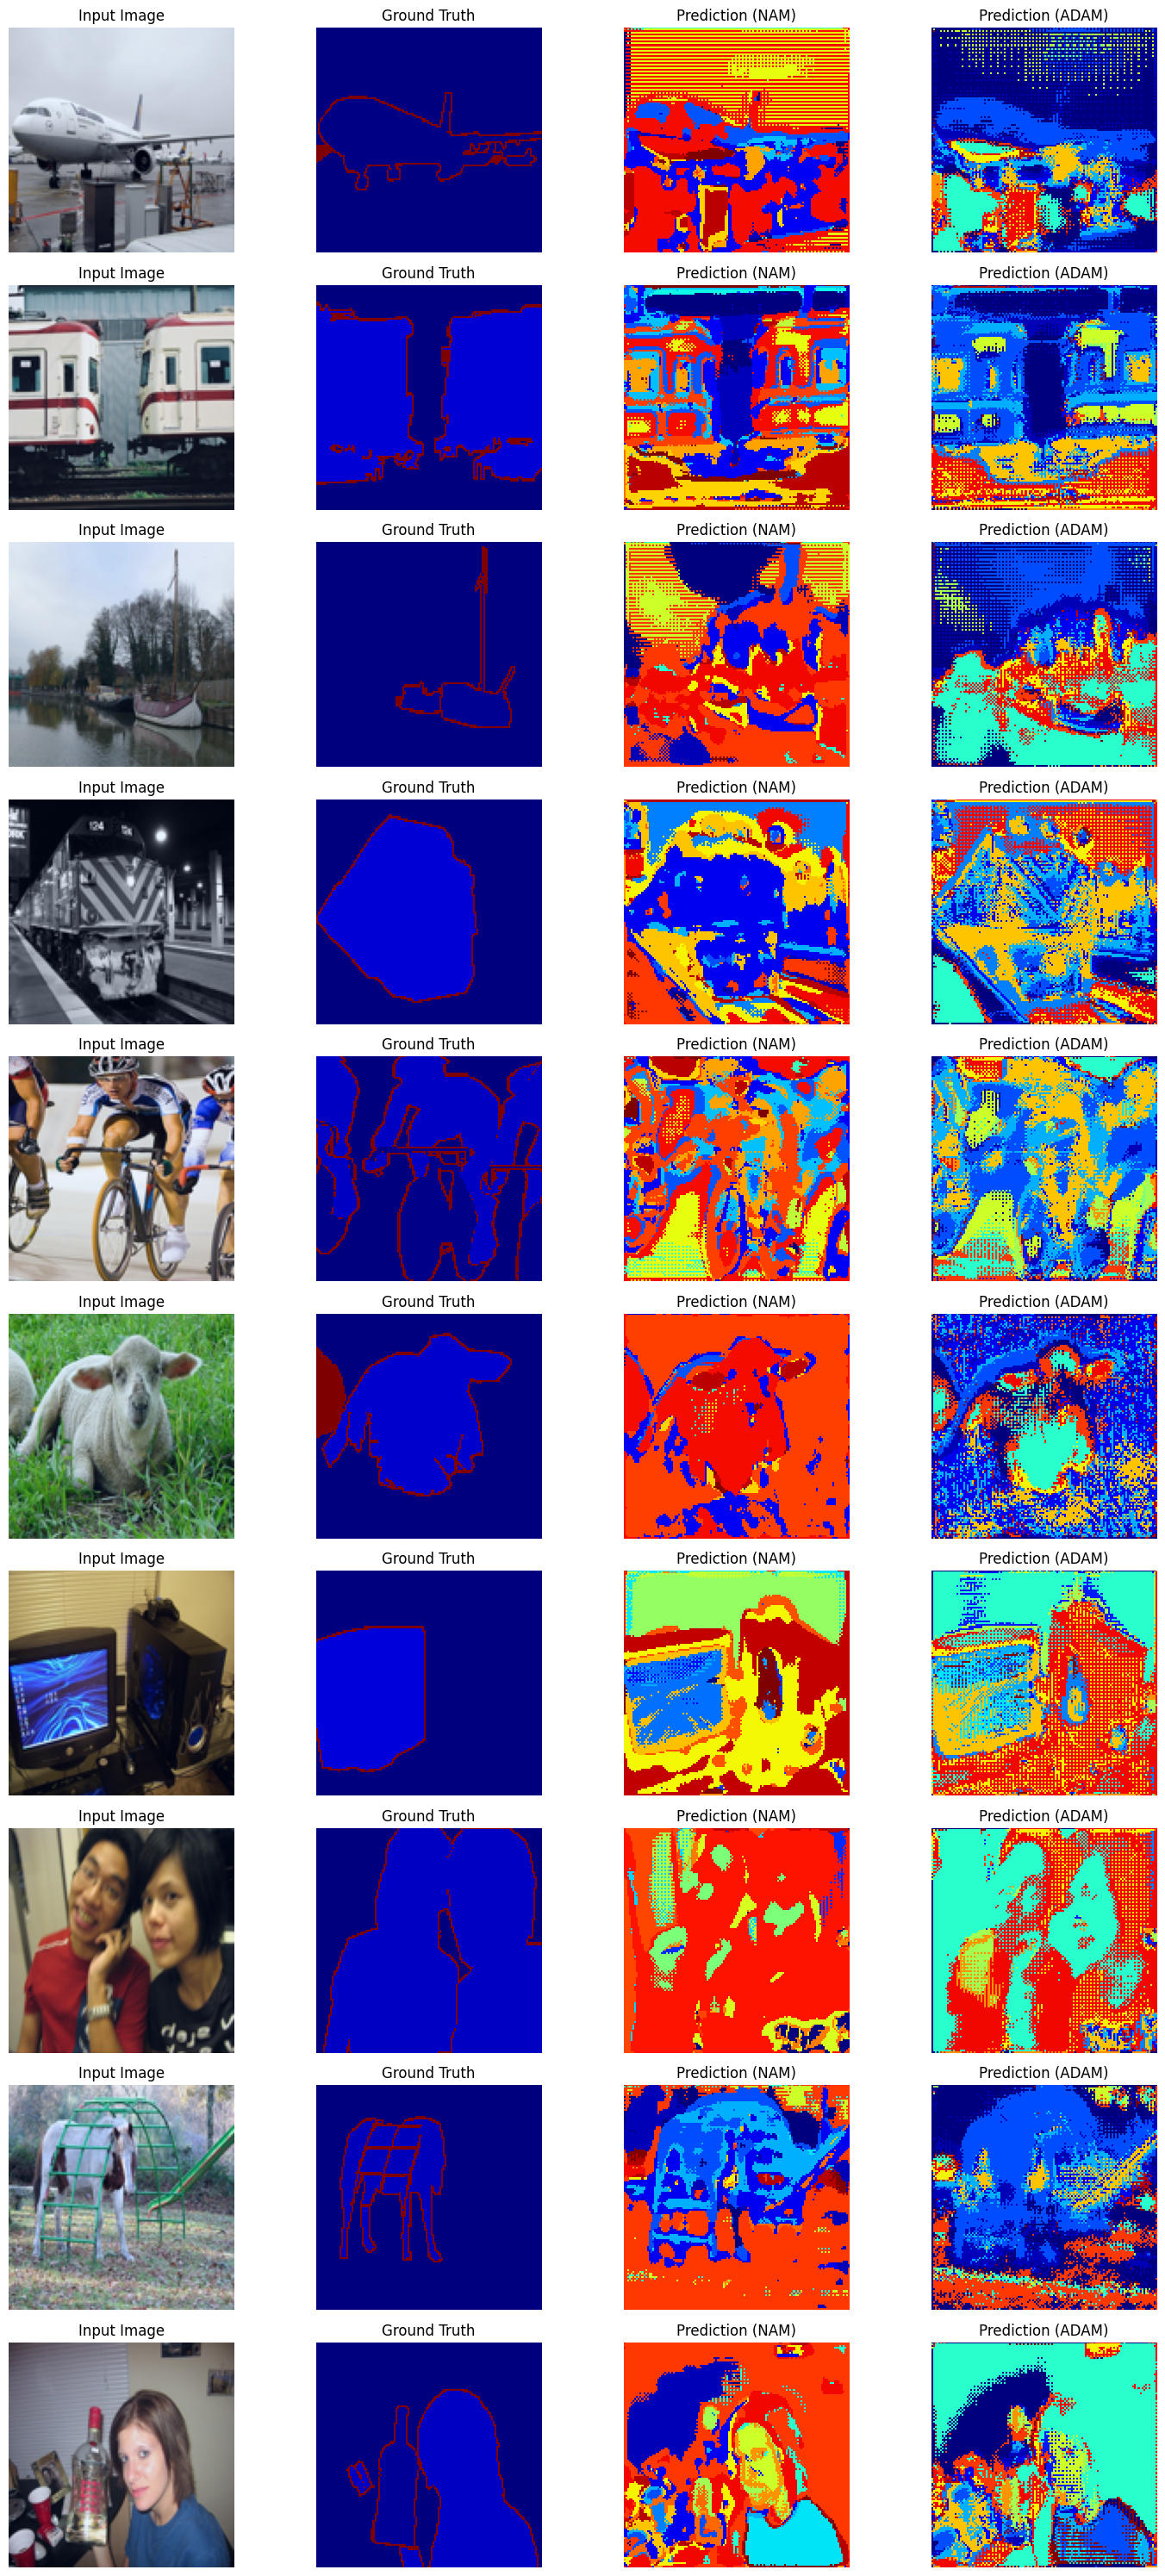

In [ ]:
import os
import matplotlib.pyplot as plt
import torch


def visualize_segmentation(models, val_loader, device, output_dir="./results", num_images=10):
    """
    Visualize segmentation results for a few validation images.

    Args:
    - models (dict): Dictionary containing trained models (e.g., {'NAM': model_nam, 'ADAM': model_adam}).
        Each model should produce predictions that align with the dataset format.
    - val_loader (DataLoader): DataLoader for the validation dataset. Supplies input images and corresponding ground truth masks.
    - device (torch.device): Device (CPU or GPU) to run the inference.
    - output_dir (str): Directory to save the visualizations.
    - num_images (int): Number of images to visualize from the validation set.

    Purpose:
    - Fetches `num_images` from the validation DataLoader.
    - Runs each model to predict segmentation masks for the same images.
    - Displays input images, ground truth masks, and predicted masks from each model side-by-side.
    """

    os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists

    # ---------------------------------
    # Prepare Models for Evaluation
    # ---------------------------------
    for model in models.values():
        model.eval()  # Set each model to evaluation mode to disable dropout/batch-norm updates

    # ---------------------------------
    # Fetch a Subset of Validation Data
    # ---------------------------------
    val_iter = iter(val_loader)  # Create an iterator over the validation DataLoader
    images, masks = next(val_iter)  # Get a batch of images and corresponding ground truth masks
    images, masks = images[:num_images].to(device), masks[:num_images].to(device)  # Limit to `num_images` and send to device

    # ---------------------------------
    # Model Predictions
    # ---------------------------------
    predictions = {}  # Dictionary to store predicted masks for each model
    with torch.no_grad():  # Disable gradient calculations for inference
        for name, model in models.items():
            outputs = model(images)  # Forward pass to get logits (raw class scores) for each pixel
            preds = torch.argmax(outputs, dim=1)  # Convert logits to class predictions (per-pixel argmax)
            predictions[name] = preds  # Store the predictions in the dictionary

    # ---------------------------------
    # Visualization
    # ---------------------------------
    num_cols = len(models) + 2  # Number of columns: input image + ground truth + predictions (one per model)
    fig, axes = plt.subplots(num_images, num_cols, figsize=(15, num_images * 3))  # Create subplot grid

    model_names = list(models.keys())  # Extract model names from the dictionary keys

    for idx in range(num_images):  # Iterate through the selected images
        # Normalize the input image for display (convert tensor to NumPy and rescale values)
        img = images[idx].cpu().permute(1, 2, 0).numpy()  # Convert tensor [C, H, W] -> [H, W, C]
        img = (img - img.min()) / (img.max() - img.min())  # Normalize values to range [0, 1] for visualization
        axes[idx, 0].imshow(img)  # Display input image
        axes[idx, 0].set_title("Input Image")
        axes[idx, 0].axis("off")  # Remove axis for clarity

        # Display the ground truth mask
        axes[idx, 1].imshow(masks[idx].cpu().numpy(), cmap="jet", interpolation="nearest")  # Use jet colormap for distinct class colors
        axes[idx, 1].set_title("Ground Truth")
        axes[idx, 1].axis("off")

        # Display predictions from each model
        for j, model_name in enumerate(model_names):  # Iterate through the models
            pred = predictions[model_name][idx].cpu().numpy()  # Convert prediction tensor to NumPy
            axes[idx, j + 2].imshow(pred, cmap="jet", interpolation="nearest")  # Display predicted mask
            axes[idx, j + 2].set_title(f"Prediction ({model_name})")  # Title includes model name
            axes[idx, j + 2].axis("off")

    # ---------------------------------
    # Save and Display Results
    # ---------------------------------
    plt.tight_layout()  # Adjust subplot spacing for better readability
    output_path = os.path.join(output_dir, "validation_segmentation_comparison.png")
    plt.savefig(output_path)  # Save the figure as an image file
    print(f"Saved segmentation comparison visualization to {output_path}")
    plt.show()  # Display the figure on screen


# ---------------------------------
# Call the Function
# ---------------------------------
visualize_segmentation(
    models={'NAM': model_nam, 'ADAM': model_adam},  # Provide the trained models as a dictionary
    val_loader=val_loader,  # Validation DataLoader for input images and ground truth
    device=device,  # Device for inference (e.g., CUDA or CPU)
    output_dir="./results",  # Directory to save the generated visualization
    num_images=10  # Number of images to visualize
)
